# Classification data using scikit-learn


Classification problems are those in which the feature to be predicted contains categories of values. Each of these categories are considered as a class into which the predicted value will fall into and hence has its name, classification.

In this notebook, we'll use scikit-learn to predict classes. scikit-learn provides implementations of many classification algorithms. In here, we have done a comparative study of 5 different classification algorithms. 

To help visualize what we are doing, we'll use 2D and 3D charts to show how the classes look (with 3 selected dimensions) with matplotlib and scikitplot python libraries.


<a id="top"></a>
## Table of Contents

1. [Load libraries](#load_libraries)
2. [Data exploration](#explore_data)
3. [Prepare data for building classification model](#prepare_data)
4. [Split data into train and test sets](#split_data)
5. [Helper methods for graph generation](#helper_methods)
6. [Build Naive Bayes classification model](#model_nb)
7. [Build Logistic Regression classification model](#model_lrc)
8. [Comparative study of different classification algorithms](#compare_classification)

### Quick set of instructions to work through the notebook

If you are new to Notebooks, here's a quick overview of how to work in this environment.

1. The notebook has 2 types of cells - markdown (text) such as this and code such as the one below. 
2. Each cell with code can be executed independently or together (see options under the Cell menu). When working in this notebook, we will be running one cell at a time because we need to make code changes to some of the cells.
3. To run the cell, position cursor in the code cell and click the Run (arrow) icon. The cell is running when you see the * next to it. Some cells have printable output.
4. Work through this notebook by reading the instructions and executing code cell by cell. Some cells will require modifications before you run them. 

<a id="load_libraries"></a>
## 1. Load libraries
[Top](#top)

Install python modules
NOTE! Some pip installs require a kernel restart.
The shell command pip install is used to install Python modules. Some installs require a kernel restart to complete. To avoid confusing errors, run the following cell once and then use the Kernel menu to restart the kernel before proceeding.

In [1]:
!pip install pandas==0.24.2
!pip install --user pandas_ml==0.6.1
#downgrade matplotlib to bypass issue with confusion matrix being chopped out
!pip install matplotlib==3.1.0
!pip install --user scikit-learn==0.21.3
!pip install -q scikit-plot

  Using cached pandas-0.24.2.tar.gz (11.8 MB)
  ERROR: Command errored out with exit status 1:
   command: /opt/anaconda3/envs/myenv/bin/python -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/78/cvbxyy5x47v8vk99cnyk11m00000gn/T/pip-install-lkj6ygl1/pandas_6e3c115ca12c4564a43ad1c244cb39c2/setup.py'"'"'; __file__='"'"'/private/var/folders/78/cvbxyy5x47v8vk99cnyk11m00000gn/T/pip-install-lkj6ygl1/pandas_6e3c115ca12c4564a43ad1c244cb39c2/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /private/var/folders/78/cvbxyy5x47v8vk99cnyk11m00000gn/T/pip-wheel-41yjtg0p
       cwd: /private/var/folders/78/cvbxyy5x47v8vk99cnyk11m00000gn/T/pip-install-lkj6ygl1/pandas_6e3c115ca12c4564a43ad1c244cb39c2/
  Complete output (2355 line

In [2]:
import sys
import io

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

import pandas as pd, numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import scikitplot as skplt


<a id="explore_data"></a>
## 2. Data exploration
[Top](#top)

Data can be easily loaded within IBM Watson Studio. Instructions to load data within IBM Watson Studio can be found [here](https://ibmdev1.rtp.raleigh.ibm.com/tutorials/watson-studio-using-jupyter-notebook/). The data set can be located by its name and inserted into the notebook as a pandas DataFrame as shown below.

![insert_spark_dataframe.png](https://raw.githubusercontent.com/IBM/icp4d-customer-churn-classifier/master/doc/source/images/insert_spark_dataframe.png)

The generated code comes up with a generic name and it is good practice to rename the dataframe to match the use case context.

In [3]:
df_churn_pd = pd.read_csv("https://raw.githubusercontent.com/IBM/ml-learning-path-assets/master/data/mergedcustomers_missing_values_GENDER.csv")

Each category within the churnrisk column has the following count : 
CHURNRISK
High      983
Low       699
Medium    384
dtype: int64


Text(0, 0.5, 'Frequency')

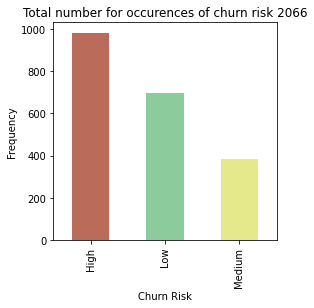

In [4]:
print( "Each category within the churnrisk column has the following count : ")
print(df_churn_pd.groupby(['CHURNRISK']).size())
#bar chart to show split of data
index = ['High','Medium','Low']
churn_plot = df_churn_pd['CHURNRISK'].value_counts(sort=True, ascending=False).plot(kind='bar',figsize=(4,4),title="Total number for occurences of churn risk " + str(df_churn_pd['CHURNRISK'].count()), color=['#BB6B5A','#8CCB9B','#E5E88B'])
churn_plot.set_xlabel("Churn Risk")
churn_plot.set_ylabel("Frequency")

<a id="prepare_data"></a>
## 3. Data preparation
[Top](#top)

Data preparation is a very important step in machine learning model building. This is because the model can perform well only when the data it is trained on is good and well prepared. Hence, this step consumes the bulk of a data scientist's time spent building models.

During this process, we identify categorical columns in the dataset. Categories needed to be indexed, which means the string labels are converted to label indices. These label indices are encoded using One-hot encoding to a binary vector with at most a single-value indicating the presence of a specific feature value from among the set of all feature values. This encoding allows algorithms which expect continuous features to use categorical features.

Final step in the data preparation process is to assemble all the categorical and non-categorical columns into a feature vector. We use VectorAssembler for this. VectorAssembler is a transformer that combines a given list of columns into a single vector column. It is useful for combining raw features and features generated by different feature transformers into a single feature vector, in order to train ML models.

In [5]:

#remove columns that are not required
df_churn_pd = df_churn_pd.drop(['ID'], axis=1)

df_churn_pd.head()


,CHURNRISK,GENDER,STATUS,CHILDREN,ESTINCOME,HOMEOWNER,AGE,TOTALDOLLARVALUETRADED,TOTALUNITSTRADED,LARGESTSINGLETRANSACTION,SMALLESTSINGLETRANSACTION,PERCENTCHANGECALCULATION,DAYSSINCELASTLOGIN,DAYSSINCELASTTRADE,NETREALIZEDGAINS_YTD,NETREALIZEDLOSSES_YTD
0,Medium,NaN,M,2,28766.9,N,47,6110.61,58,1527.6525,152.76525,8.70,2,13,0.0000,152.76525
1,Low,NaN,M,2,91272.2,Y,25,26992.70,13,13496.3500,1349.63500,3.25,4,10,1349.6350,0.00000
2,Low,NaN,S,0,73228.3,N,42,22472.25,28,11236.1250,1123.61250,7.00,4,5,1123.6125,0.00000
3,High,M,M,1,64792.3,N,52,13051.31,36,6525.6550,652.56550,9.00,3,6,0.0000,652.56550
4,High,F,S,0,93322.1,Y,40,29922.99,8,14961.4950,1496.14950,2.00,4,9,0.0000,1496.14950


In [6]:
# Defining the categorical columns 
categoricalColumns = ['GENDER', 'STATUS', 'HOMEOWNER']

print("Categorical columns : " )
print(categoricalColumns)

impute_categorical = SimpleImputer(strategy="most_frequent")
onehot_categorical =  OneHotEncoder(handle_unknown='ignore')

categorical_transformer = Pipeline(steps=[('impute',impute_categorical),('onehot',onehot_categorical)])

Categorical columns : 
['GENDER', 'STATUS', 'HOMEOWNER']


In [7]:
# Defining the numerical columns 
numericalColumns = df_churn_pd.select_dtypes(include=[np.float,np.int]).columns

print("Numerical columns : " )
print(numericalColumns)

scaler_numerical = StandardScaler()

numerical_transformer = Pipeline(steps=[('scale',scaler_numerical)])


Numerical columns : 
Index(['CHILDREN', 'ESTINCOME', 'AGE', 'TOTALDOLLARVALUETRADED',
       'TOTALUNITSTRADED', 'LARGESTSINGLETRANSACTION',
       'SMALLESTSINGLETRANSACTION', 'PERCENTCHANGECALCULATION',
       'DAYSSINCELASTLOGIN', 'DAYSSINCELASTTRADE', 'NETREALIZEDGAINS_YTD',
       'NETREALIZEDLOSSES_YTD'],
      dtype='object')


<ipython-input-7-e3cc96e09416>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numericalColumns = df_churn_pd.select_dtypes(include=[np.float,np.int]).columns
<ipython-input-7-e3cc96e09416>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.ht

In [8]:
preprocessorForCategoricalColumns = ColumnTransformer(transformers=[('cat', categorical_transformer, categoricalColumns)],
                                            remainder="passthrough")
preprocessorForAllColumns = ColumnTransformer(transformers=[('cat', categorical_transformer, categoricalColumns),('num',numerical_transformer,numericalColumns)],
                                            remainder="passthrough")


#. The transformation happens in the pipeline. Temporarily done here to show what intermediate value looks like
df_churn_pd_temp = preprocessorForCategoricalColumns.fit_transform(df_churn_pd)
print("Data after transforming :")
print(df_churn_pd_temp)

df_churn_pd_temp_2 = preprocessorForAllColumns.fit_transform(df_churn_pd)
print("Data after transforming :")
print(df_churn_pd_temp_2)

Data after transforming :
[[1.0 0.0 0.0 ... 13 0.0 152.76525]
 [1.0 0.0 0.0 ... 10 1349.635 0.0]
 [1.0 0.0 0.0 ... 5 1123.6125 0.0]
 ...
 [1.0 0.0 0.0 ... 11 0.0 82.50825]
 [1.0 0.0 0.0 ... 5 930.093 0.0]
 [0.0 1.0 0.0 ... 8 1041.604 0.0]]
Data after transforming :
[[1.0 0.0 0.0 ... -0.6792731303453047 -0.5106065181930338 'Medium']
 [1.0 0.0 0.0 ... 1.8354629319820521 -0.7959345330293706 'Low']
 [1.0 0.0 0.0 ... 1.4143217110983428 -0.7959345330293706 'Low']
 ...
 [1.0 0.0 0.0 ... -0.6792731303453047 -0.6418293606808149 'Medium']
 [1.0 0.0 0.0 ... 1.053742394902809 -0.7959345330293706 'Low']
 [0.0 1.0 0.0 ... 1.261517632686496 -0.7959345330293706 'Low']]


In [9]:
# prepare data frame for splitting data into train and test datasets

features = []
features = df_churn_pd.drop(['CHURNRISK'], axis=1)

label_churn = pd.DataFrame(df_churn_pd, columns = ['CHURNRISK']) 
label_encoder = LabelEncoder()
label = df_churn_pd['CHURNRISK']

label = label_encoder.fit_transform(label)
print("Encoded value of Churnrisk after applying label encoder : " + str(label))




Encoded value of Churnrisk after applying label encoder : [2 1 1 ... 2 1 1]


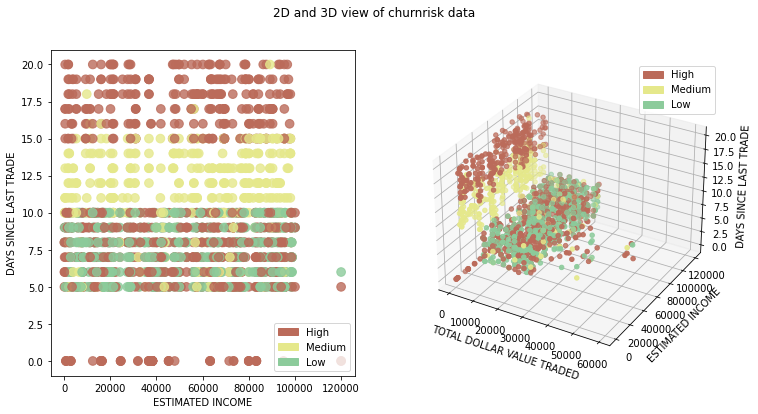

In [10]:
area = 75
x = df_churn_pd['ESTINCOME']
y = df_churn_pd['DAYSSINCELASTTRADE']
z = df_churn_pd['TOTALDOLLARVALUETRADED']

pop_a = mpatches.Patch(color='#BB6B5A', label='High')
pop_b = mpatches.Patch(color='#E5E88B', label='Medium')
pop_c = mpatches.Patch(color='#8CCB9B', label='Low')
def colormap(risk_list):
    cols=[]
    for l in risk_list:
        if l==0:
            cols.append('#BB6B5A')
        elif l==2:
            cols.append('#E5E88B')
        elif l==1:
            cols.append('#8CCB9B')
    return cols

fig = plt.figure(figsize=(12,6))
fig.suptitle('2D and 3D view of churnrisk data')

# First subplot
ax = fig.add_subplot(1, 2,1)

ax.scatter(x, y, alpha=0.8, c=colormap(label), s= area)
ax.set_ylabel('DAYS SINCE LAST TRADE')
ax.set_xlabel('ESTIMATED INCOME')

plt.legend(handles=[pop_a,pop_b,pop_c])

# Second subplot
ax = fig.add_subplot(1,2,2, projection='3d')

ax.scatter(z, x, y, c=colormap(label), marker='o')

ax.set_xlabel('TOTAL DOLLAR VALUE TRADED')
ax.set_ylabel('ESTIMATED INCOME')
ax.set_zlabel('DAYS SINCE LAST TRADE')

plt.legend(handles=[pop_a,pop_b,pop_c])

plt.show()


<a id="split_data"></a>
## 4. Split data into test and train
This will split our sample data into a training set and a testing set. The training set will be the data used to build the model. The testing set will be used as a basis to compare how well the model predicts values.
<br />
[Top](#top)



In [11]:

X_train, X_test, y_train, y_test = train_test_split(features,label , random_state=0)

print("Dimensions of datasets that will be used for training : Input features"+str(X_train.shape)+ 
      " Output label" + str(y_train.shape))
print("Dimensions of datasets that will be used for testing : Input features"+str(X_test.shape)+ 
      " Output label" + str(y_test.shape))



Dimensions of datasets that will be used for training : Input features(1549, 15) Output label(1549,)
Dimensions of datasets that will be used for testing : Input features(517, 15) Output label(517,)



<a id="helper_methods"></a>
## 5. Helper methods for graph generation
These functions will be used to generate the histograms we will use to compare our algorithms against the actual data.
<br />
[Top](#top)



In [12]:
def colormap(risk_list):
    cols=[]
    for l in risk_list:
        if l==0:
            cols.append('#BB6B5A')
        elif l==2:
            cols.append('#E5E88B')
        elif l==1:
            cols.append('#8CCB9B')
    return cols

def two_d_compare(y_test,y_pred,model_name):
    #y_pred = label_encoder.fit_transform(y_pred)
    #y_test = label_encoder.fit_transform(y_test)
    area = (12 * np.random.rand(40))**2 
    plt.subplots(ncols=2, figsize=(10,4))
    plt.suptitle('Actual vs Predicted data : ' +model_name + '. Accuracy : %.2f' % accuracy_score(y_test, y_pred))

    plt.subplot(121)
    plt.scatter(X_test['ESTINCOME'], X_test['DAYSSINCELASTTRADE'], alpha=0.8, c=colormap(y_test))
    plt.title('Actual')
    plt.legend(handles=[pop_a,pop_b,pop_c])

    plt.subplot(122)
    plt.scatter(X_test['ESTINCOME'], X_test['DAYSSINCELASTTRADE'],alpha=0.8, c=colormap(y_pred))
    plt.title('Predicted')
    plt.legend(handles=[pop_a,pop_b,pop_c])

    plt.show()
    
x = X_test['TOTALDOLLARVALUETRADED']
y = X_test['ESTINCOME']
z = X_test['DAYSSINCELASTTRADE']

pop_a = mpatches.Patch(color='#BB6B5A', label='High')
pop_b = mpatches.Patch(color='#E5E88B', label='Medium')
pop_c = mpatches.Patch(color='#8CCB9B', label='Low')

def three_d_compare(y_test,y_pred,model_name):
    fig = plt.figure(figsize=(12,10))
    fig.suptitle('Actual vs Predicted (3D) data : ' +model_name + '. Accuracy : %.2f' % accuracy_score(y_test, y_pred))
    
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(x, y, z, c=colormap(y_test), marker='o')
    ax.set_xlabel('TOTAL DOLLAR VALUE TRADED')
    ax.set_ylabel('ESTIMATED INCOME')
    ax.set_zlabel('DAYS SINCE LAST TRADE')
    plt.legend(handles=[pop_a,pop_b,pop_c])
    plt.title('Actual')

    ax = fig.add_subplot(122, projection='3d')
    ax.scatter(x, y, z, c=colormap(y_pred), marker='o')
    ax.set_xlabel('TOTAL DOLLAR VALUE TRADED')
    ax.set_ylabel('ESTIMATED INCOME')
    ax.set_zlabel('DAYS SINCE LAST TRADE')
    plt.legend(handles=[pop_a,pop_b,pop_c])
    plt.title('Predicted')

    plt.show()
    

def model_metrics(y_test,y_pred):
    print("Decoded values of Churnrisk after applying inverse of label encoder : " + str(np.unique(y_pred)))

    skplt.metrics.plot_confusion_matrix(y_test,y_pred,text_fontsize="small",cmap='Greens',figsize=(6,4))
    plt.show()
    
    #print("The classification report for the model : \n\n"+ classification_report(y_test, y_pred))


<a id="model_nb"></a>
## 6. Build Naive Bayes classification model
[Top](#top)

Applies the bayesian theorem to calculate the probabilty of a data point belonging to a particular class. Given the probability of certain related values,the formula to calculate the probabilty of an event B given event A to occur is calculated as follows.

In [13]:
from sklearn.naive_bayes import MultinomialNB

model_name = 'Naive Bayes Classifier'

nbClassifier = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

nb_model = Pipeline(steps=[('preprocessor', preprocessorForCategoricalColumns),('classifier', nbClassifier)]) 

#fit the model to the training data
nb_model.fit(X_train,y_train)

y_pred_nb= nb_model.predict(X_test)


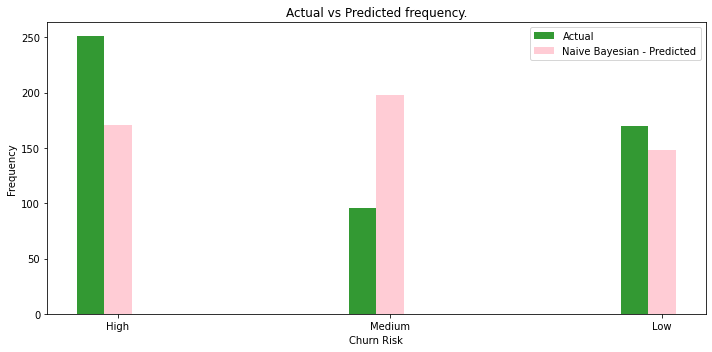

In [14]:
uniqueValues, occurCount = np.unique(y_test, return_counts=True)
frequency_actual = (occurCount[0],occurCount[2],occurCount[1])

uniqueValues, occurCount = np.unique(y_pred_nb, return_counts=True)
frequency_predicted_nb = (occurCount[0],occurCount[2],occurCount[1])

n_groups = 3
fig, ax = plt.subplots(figsize=(10,5))
index = np.arange(n_groups)
bar_width = 0.1
opacity = 0.8

rects1 = plt.bar(index, frequency_actual, bar_width,
alpha=opacity,
color='g',
label='Actual')

rects2 = plt.bar(index + bar_width, frequency_predicted_nb, bar_width,
alpha=opacity,
color='pink',
label='Naive Bayesian - Predicted')


plt.xlabel('Churn Risk')
plt.ylabel('Frequency')
plt.title('Actual vs Predicted frequency.')
plt.xticks(index + bar_width, ('High', 'Medium', 'Low'))
plt.legend()

plt.tight_layout()
plt.show()

<a id="model_lrc"></a>
## 7. Build Logistic Regression classification model
[Top](#top)

A logistic function is applied to the outcome of linear regression. The logistic function is also referred to as sigmoid function. This outputs a value between 0 and 1. We then select a line that depends on the use case, and any data point with probability value above the line is classified into the class represented by 1 and the data point below the line is classified into the class represented by 0.

<span style="color:red">Complete the code and set up the pipeline, fit the model, and predict y values. <br />Hint: Look at the structure of the code used for the Naive Bayes model</span>

In [15]:
from sklearn.linear_model import LogisticRegression

model_name = "Logistic Regression Classifier"

logisticRegressionClassifier = LogisticRegression(random_state=0,multi_class='auto',solver='lbfgs',max_iter=1000)

##Complete the code below 
lrc_model = 

#fit the model to the training data

y_pred_lrc = 


SyntaxError: invalid syntax (<ipython-input-15-ba73e201de04>, line 8)

Uncomment and run the following cell to see the answers.

In [20]:
# %load https://raw.githubusercontent.com/IBM/intro-to-ml-with-sklearn/main/notebook-answers/classification-answers-7.1.py

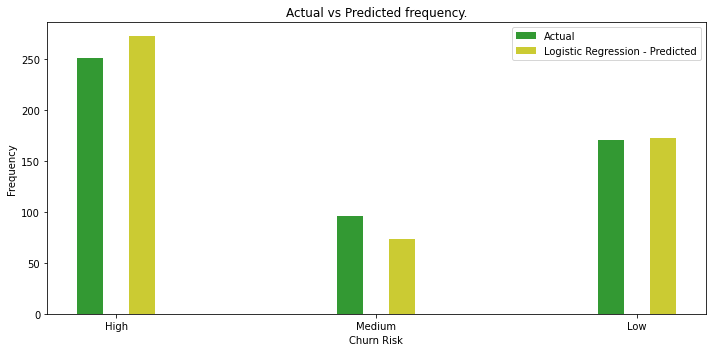

In [21]:
uniqueValues, occurCount = np.unique(y_test, return_counts=True)
frequency_actual = (occurCount[0],occurCount[2],occurCount[1])

uniqueValues, occurCount = np.unique(y_pred_lrc, return_counts=True)
frequency_predicted_lrc = (occurCount[0],occurCount[2],occurCount[1])

n_groups = 3
fig, ax = plt.subplots(figsize=(10,5))
index = np.arange(n_groups)
bar_width = 0.1
opacity = 0.8

rects1 = plt.bar(index, frequency_actual, bar_width,
alpha=opacity,
color='g',
label='Actual')

rects2 = plt.bar(index + bar_width*2, frequency_predicted_lrc, bar_width,
alpha=opacity,
color='y',
label='Logistic Regression - Predicted')

plt.xlabel('Churn Risk')
plt.ylabel('Frequency')
plt.title('Actual vs Predicted frequency.')
plt.xticks(index + bar_width, ('High', 'Medium', 'Low'))
plt.legend()

plt.tight_layout()
plt.show()


<a id="compare_classification"></a>
## 8. Comparative study of different classification algorithms. 
[Top](#top)

In the bar chart below, we have compared the different classification algorithm against the actual values. 
 

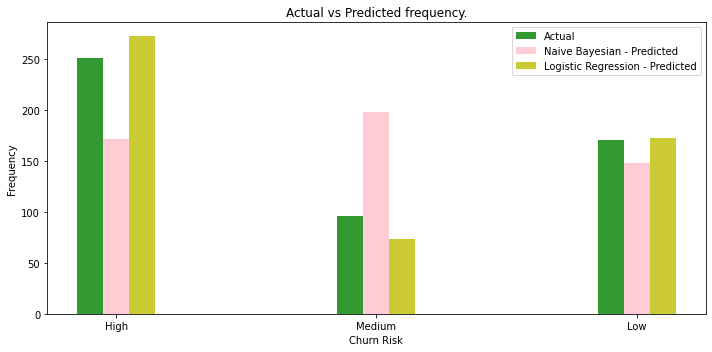

In [22]:
uniqueValues, occurCount = np.unique(y_test, return_counts=True)
frequency_actual = (occurCount[0],occurCount[2],occurCount[1])

uniqueValues, occurCount = np.unique(y_pred_lrc, return_counts=True)
frequency_predicted_lrc = (occurCount[0],occurCount[2],occurCount[1])

uniqueValues, occurCount = np.unique(y_pred_nb, return_counts=True)
frequency_predicted_nb = (occurCount[0],occurCount[2],occurCount[1])

n_groups = 3
fig, ax = plt.subplots(figsize=(10,5))
index = np.arange(n_groups)
bar_width = 0.1
opacity = 0.8

rects1 = plt.bar(index, frequency_actual, bar_width,
alpha=opacity,
color='g',
label='Actual')

rects2 = plt.bar(index + bar_width, frequency_predicted_nb, bar_width,
alpha=opacity,
color='pink',
label='Naive Bayesian - Predicted')

rects3 = plt.bar(index + bar_width*2, frequency_predicted_lrc, bar_width,
alpha=opacity,
color='y',
label='Logistic Regression - Predicted')

plt.xlabel('Churn Risk')
plt.ylabel('Frequency')
plt.title('Actual vs Predicted frequency.')
plt.xticks(index + bar_width, ('High', 'Medium', 'Low'))
plt.legend()

plt.tight_layout()
plt.show()

In general, we see that the predictions around the Medium values is low on accuracy. One reason for that could be that the number of entries for the Medium values were much less represented than High and Low values. Further testing can be done by either increasing the number of Medium entries or involving several data fabrication techniques. 

<p><font size=-1 color=gray>
&copy; Copyright 2019 IBM Corp. All Rights Reserved.
<p>
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file
except in compliance with the License. You may obtain a copy of the License at
https://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the
License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either
express or implied. See the License for the specific language governing permissions and
limitations under the License.
</font></p>